# PS2: Bellman-Ford Shortest Path Algorithm
This problem set introduces the Bellman–Ford algorithm for finding shortest paths from a single source to all other vertices in a weighted graph. 

Bellman–Ford can handle negative edge weights (unlike Dijkstra's algorithm), which makes it useful for some problems, but it is slower: time complexity is $\mathcal{O}(|\mathcal{V}|\cdot|\mathcal{E}|)$.

> __Problem overview:__ We'll solve a task allocation problem where workers have preferences for different tasks, encoded as edge weights that can be negative (worker likes the task), positive (worker dislikes the task), or zero (worker is indifferent). This preference encoding creates a graph with __negative edge weights__, making Bellman-Ford the appropriate choice over Dijkstra's algorithm.

You'll build a small example, run the algorithm, and visualize the resulting paths so you can see how the shortest path is determined.

___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [include command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Set up the environment:

In [3]:
include(joinpath(@__DIR__, "Include-solution.jl"));

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Why Bellman-Ford?
Before diving into the implementation, let's understand why we're using the Bellman-Ford algorithm for this particular problem.

> __Handling negative weights:__ Unlike Dijkstra's algorithm, Bellman-Ford can handle __negative edge weights__. In our task allocation problem, negative weights represent worker preferences (they like the task), while positive weights represent dislikes. Dijkstra's algorithm assumes all weights are non-negative, so it would fail on our preference graph.

> __Algorithm complexity:__ Bellman-Ford has time complexity $\mathcal{O}(|\mathcal{V}|\cdot|\mathcal{E}|)$, which is slower than Dijkstra's $\mathcal{O}((|\mathcal{V}|+|\mathcal{E}|)\log|\mathcal{V}|)$ when using a priority queue. However, the ability to handle negative weights makes it essential for many real-world optimization problems.

> __Detection of negative cycles:__ An important feature of Bellman-Ford is that it can __detect negative cycles__ in the graph. A negative cycle would indicate an impossible situation in optimization—you could keep going around the cycle to reduce cost indefinitely. In our task allocation context, this might represent conflicting preferences that make the problem unsolvable.

> __When Bellman-Ford fails:__ The algorithm will correctly identify if the graph contains a negative cycle reachable from the source. If such a cycle exists, there is no shortest path (you can always find a path with lower cost by going around the cycle more times). In practice, this helps identify flawed problem formulations.

### Constants
Let's define some constants that will be used throughout the notebook. See the comments for a description of each constant, what it represents, its value, units, etc.

In [7]:
# We are going to plot the path through a graph, so let's provide the coordinates for each node, i.e., the layout
# This layout looks like our schematic but you can rearrange this if you want!
node_coordinates = [

    # source node (you)
    10.0 10.0 ; # 1 source node s (x,y) coordinates

    # people nodes (workers)
    11.0 11.0 ; # 2 people node (x,y) coordinates
    11.0 10.0 ; # 3 people node (x,y) coordinates
    11.0 9.0 ; # 4 people node (x,y) coordinates

    # job nodes (tasks)
    12.0 11.0 ; # 5 job node (x,y) coordinates
    12.0 10.0 ; # 6 job node (x,y) coordinates
    12.0 9.0 ; # 7 job node (x,y) coordinates

    # sink nodes (targets, tasks done!)
    13.0 11.0 ; # 8 sink node t (x,y) coordinates
    13.0 10.0 ; # 9 sink node t (x,y) coordinates
    13.0 9.0 ; # 10 sink node t (x,y) coordinates
];

### Implementations
Below are helper routines used in this notebook. The `reconstruct_path(...)` function turns the predecessor map into a path for a source-target pair. Skim the docstrings if you want the quick idea, or read the comments for implementation details.

In [9]:
"""
    function reconstruct_path(pmap, node)

Reconstructs the shortest path from the source to a given node using the predecessor map.

### Arguments
- `pmap`: A dictionary mapping each node to its predecessor in the shortest path tree.
- `node`: The target node for which to reconstruct the path.

### Returns
- An array representing the path from source to the target node.
"""
function reconstruct_path(pmap, node)
    path = Int[]
    cur = node
    while cur !== nothing
        push!(path, cur)
        cur = get(pmap, cur, nothing)
    end
    reverse!(path)
    return path
end;

___

## Task 1: Build a task-allocation model
You're node `1` (the source). We have a small bipartite setup: worker nodes on the left and task nodes on the right. The graph is directed, with edges from workers to tasks, a starting node `1` that connects to all workers, and completion nodes that all tasks connect to. We want to assign workers to tasks in a way that __minimizes the cost__ of the assignment. 

The graph and weights are specified in the `data/Balanced-Bipartite.edgelist` file, where each record is defined as:

> __Records:__ Each record in our edgelist file has the comma-separated fields: `source,` `target,` `cost,` `lb capacity,` `ub capacity`. The `source` field is the id for the source node, e.g., `1`, the `target` field is the target node id, the `cost` is the cost of assigning the source node to the target node, the `lb capacity` is the lower bound capacity for the edge, and the `ub capacity` is the upper bound capacity for the edge.

In this case study, we'll ignore the capacity constraints, but these will become important a few lectures down the road, so hang tight! Now let's set up our edge parser __callback function__:

In [12]:
"""
    function edgerecordparser(record::String, delim::Char=',') -> Tuple{Int, Int, Float64} | Nothing

This method is called to parse a single edge record from the edgelist file. It gets called once for each record in the file. 
The function splits the record into fields based on the specified delimiter and extracts the source node, target node, and cost (weight) of the edge. 
It returns a tuple containing these values. If the record does not have the expected number of fields, it returns `nothing`.

### Arguments
- `record`: The edge record string to parse.
- `delim`: The delimiter used to split the record.

### Returns
- A tuple containing the source node, target node, and cost of the edge, or `nothing` if the record is invalid.
"""
function edgerecordparser(record::String, delim::Char=',')
    
    # record (five fields)
    # source, target, cost, lb, ub

    fields = split(record, delim) # this assumes a record of the form "source,target,weight"
    if length(fields) < 5 # we have 5 fields
        return nothing
    end

    # get my data -
    source = parse(Int, fields[1]) # source ID
    target = parse(Int, fields[2]) # target ID
    cost = parse(Float64, fields[3]) # edge weight
    
    # return a tuple -
    return (source, target, cost) # we are ignoring the capacity constraints
end;

Next, let's set the path to the edge list file in the `path_to_edge_file::String` variable:

In [14]:
path_to_edge_file = joinpath(_PATH_TO_DATA, "Balanced-Bipartite.edgelist"); # this points to the graph shown above

Next, construct a dictionary [of `MyEdgeModel` instances](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyGraphEdgeModel) which stores the data for the edges. Let's save our edge models in the `myedgemodels::Dict{Int64, MyGraphEdgeModel}` dictionary. 

> __What's in the edge dictionary?__ The keys in the edge dictionary will be the edge IDs (which we can assume are unique), and the values will be the corresponding `MyGraphEdgeModel` instances. Here, we've used the line index in the edge file as the edge ID.

We'll use the `myedgemodels` dictionary to build a directed graph model for the Bellman-Ford algorithm.

In [16]:
myedgemodels = let

    # initialize -
    myedgemodels = nothing; # initialize to nothing
    myedgemodels = MyGraphEdgeModels(path_to_edge_file, edgerecordparser, delim=',', comment='#')

    myedgemodels # return the edge models
end;

### What does our edge model tell us?
The entries in our edge model dictionary, and particularly the weight fields, tell us the preferences of the workers for the tasks. By analyzing the weights, we can identify which tasks are more desirable for each worker, and vice versa.

For example, consider edges `11` and `14`. Edge `11` describes the preferences of worker `3` for task `7`, while edge `14` describes the preferences of worker `4` for task `7`. Thus, by comparing $w_{37}$ and $w_{47}$, we can determine which worker prefers the task more.

In [18]:
let

    # initialize -
    edge_model_11 = myedgemodels[11]; # this is the edge model for edge 11
    edge_model_14 = myedgemodels[14]; # this is the edge model for edge 14

    w37 = edge_model_11.weight; # this is the weight for edge 11
    w47 = edge_model_14.weight; # this is the weight for edge 14

    if min(w37, w47) == w37
        println("Worker 3 prefers task 7 over worker 4"); # Worker 3's preference is stronger
    else
        println("Worker 4 prefers task 7 over worker 3"); # Worker 4's preference is stronger
    end
end

Worker 4 prefers task 7 over worker 3


We could also create an adjacency matrix to represent the preferences of all workers for all tasks. This matrix could be used to quickly identify the most preferred task for each worker, as well as to analyze the overall distribution of preferences across workers.

> __Adjacency-like weight matrix:__ The adjacency matrix $\mathbf{W}\in\mathbb{R}^{n\times{n}}$, where $n$ is the number of nodes in the graph. Thus, $w_{ij}\in\mathbf{W}$ is the weight of the edge from node $i$ to node $j$. Most of the elements in $\mathbf{W}$ will be zero because our graph is sparse. A value of $w_{ij} = 0$ indicates __either__ no connection or no preference between node $i$ and $j$, while $w_{ij}>0$ indicates dislike, and $w_{ij}<0$ indicates like.

We'll save the weight matrix $\mathbf{W}$ in the `W::Array{Float64,2}` variable:

In [20]:
W = let

    # build a node set from the edgemodels -
    nodes = Set{Int64}();
    for (k,v) ∈ myedgemodels
        push!(nodes, v.source);
        push!(nodes, v.target);
    end
    nodes_array = nodes |> collect |> sort;

    # create an edges dictionary -
    edges = Dict{Tuple{Int64, Int64}, Float64}();
    for (k, v) ∈ myedgemodels
        edges[(v.source, v.target)] = v.weight;
    end

    # initialize -
    n = nodes_array |> length;
    W = zeros(Float64, n, n); # this is the weight matrix

    for i ∈ 1:n
        row_index = nodes_array[i]; # this is the row index
        for j ∈ 1:n
            col_index = nodes_array[j]; # this is the column index

            # do we have an edge (row_index, col_index)?
            if haskey(edges, (row_index, col_index)) == true
                W[i,j] = edges[(row_index, col_index)];
            end
        end
    end
    W;
end

10×10 Matrix{Float64}:
 0.0  1.0  1.0  1.0  0.0  0.0   0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  -2.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  2.0  4.0  -1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  -2.5  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0

If we look at columns $5, 6, 7$ (which correspond to the task nodes), we can get a sense of how desirable a particular task is. For example, if we sum each task column, we can rank each task based on its desirability:

In [22]:
let

    # initialize -
    task_columns = [5,6,7];
    desirability_scores = zeros(Float64, length(task_columns));

    # compute a desirability score for each task -
    for (idx, col) ∈ enumerate(task_columns)
        desirability_scores[idx] = sum(W[:, col]); # sum the column
    end

    # rank tasks by desirability - 
    ranked_tasks = sortperm(desirability_scores, rev=false); # smallest to largest (negative is good)
    println("Task ranking based on desirability (from most to least desirable): $(task_columns[ranked_tasks])");
end

Task ranking based on desirability (from most to least desirable): [7, 5, 6]


Finally, we can build a graph instance. Since this is a directed graph, we'll construct [a `MySimpleDirectedGraphModel` instance](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MySimpleDirectedGraphModel) using [a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/#VLDataScienceMachineLearningPackage.build). Let's save our graph model in the `directedgraphmodel::MySimpleDirectedGraphModel` variable.

In [24]:
directedgraphmodel = let
    
    # initialize -
    directedgraphmodel = nothing; # default value is nothing
    
    # TODO: build the directedgraphmodel from the edge models by calling the build function
    # TODO: the type of thing you are building is MySimpleDirectedGraphModel
    # TODO: the edge models are stored in myedgemodels dictionary from above
    directedgraphmodel = build(MySimpleDirectedGraphModel, myedgemodels);

    # return
    directedgraphmodel; 
end

MySimpleDirectedGraphModel(Dict{Int64, MyGraphNodeModel}(5 => MyGraphNodeModel(5, nothing), 4 => MyGraphNodeModel(4, nothing), 6 => MyGraphNodeModel(6, nothing), 7 => MyGraphNodeModel(7, nothing), 2 => MyGraphNodeModel(2, nothing), 10 => MyGraphNodeModel(10, nothing), 9 => MyGraphNodeModel(9, nothing), 8 => MyGraphNodeModel(8, nothing), 3 => MyGraphNodeModel(3, nothing), 1 => MyGraphNodeModel(1, nothing)…), Dict{Tuple{Int64, Int64}, Number}((4, 5) => 1.0, (1, 2) => 1.0, (2, 5) => 0.0, (3, 7) => -1.0, (1, 3) => 1.0, (4, 6) => 0.0, (1, 4) => 1.0, (2, 6) => 1.0, (7, 10) => 1.0, (4, 7) => -2.5…), Dict{Int64, Set{Int64}}(5 => Set([8]), 4 => Set([5, 6, 7]), 6 => Set([9]), 7 => Set([10]), 2 => Set([5, 6, 7]), 10 => Set(), 9 => Set(), 8 => Set(), 3 => Set([5, 6, 7]), 1 => Set([4, 2, 3])…), Dict(5 => (2, 6), 12 => (4, 7), 8 => (3, 6), 1 => (1, 2), 6 => (2, 7), 11 => (4, 6), 9 => (3, 7), 14 => (6, 9), 3 => (1, 4), 7 => (3, 5)…))

`Unhide` the code block below to see how we visualized the graph for the example. We start at node `1` (the source node) and will compute the shortest path to a specified target node, an element of the set $\{8, 9, 10\}$.

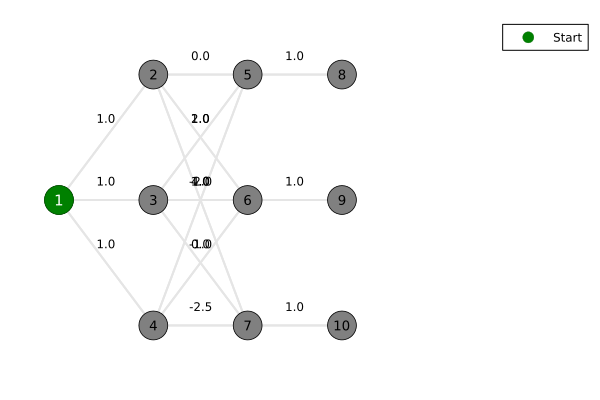

In [26]:
let

    # initialize -
    base_graphmodel = directedgraphmodel;
    source_node = 1; # this is where we start

    # draw -
    q = plot();
    for (k,v) ∈ base_graphmodel.edgesinverse
       
        # now, get the source,target node index for this edge
        s = v[1];
        t = v[2];
        # draw baseline edge
        plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:gray90, lw=2, label="")
        
        # add weight annotation to edges -
        mx = (node_coordinates[s,1] + node_coordinates[t,1]) / 2
        my = (node_coordinates[s,2] + node_coordinates[t,2]) / 2
        c = round(base_graphmodel.edges[(s,t)], digits=2)
        annotate!(mx, my + 0.15, text(string(c), 8, :black))
    end
    scatter!(node_coordinates[:,1], node_coordinates[:,2], axis=nothing, border=:none, label="", c=:gray, ms=16)
    
   
    scatter!([node_coordinates[source_node,1]], [node_coordinates[source_node,2]], 
             c=:green, ms=16, markerstroke=2, markerstrokecolor=:darkgreen, 
             label="Start")

    # number the nodes -
    n_nodes = size(node_coordinates, 1)
    for i in 1:n_nodes
        x = node_coordinates[i,1]
        y = node_coordinates[i,2]
        if i == source_node
            # white text for the green source node
            annotate!(x, y, text(string(i), 10, :white))
        else
            # black text for other nodes
            annotate!(x, y, text(string(i), 9, :black))
        end
    end

    # set the global plot attributes
    plot!(axis=nothing, border=:none, legend=:outertopright, legendfontsize=8, 
          background_color=:white, xlim=(9.5, 14.5), ylim=(8.5, 11.5))

    current() # show the current plot
end

In [27]:
do_I_see_my_graph_figure = true; # {true,false} - set to true if you see the graph figure, otherwise set to false

___

## Task 2: Compute the best assignment
In this task, we'll compute the best assignment of workers to tasks, e.g., the shortest path from the source node (you) to the sink nodes (tasks done) using the Bellman-Ford algorithm.

This is a simple test case, so we can look at the edge weights and guess the shortest paths using our intuition, without running the algorithm. Let's do that so we can check if what we think should happen actually happens.

> __Intuition:__ Suppose we specify a task node $j$. Then, the cost of having person $i$ assigned to task $j$ is just the edge weight $w_{ij}$. Thus, a minimum cost assignment for task $j$ would be: $i^{\star} \leftarrow \arg\min_{i} w_{ij}$. Reminder: $w_{ij} = 0$ indicates no preference, $w_{ij} > 0$ indicates dislike, and $w_{ij} < 0$ indicates like.

> __Why this works:__ The Bellman-Ford algorithm finds shortest paths by minimizing the total cost from source to destination. In our bipartite graph, any path from you (node 1) to a completed task (nodes 8-10) must go through exactly one worker and one task. So the total cost of assigning worker $i$ to complete task $j$ is: $\text{cost}(1 \to i) + \text{cost}(i \to j) + \text{cost}(j \to \text{sink})$. Since we set the cost from you to each worker as 0 (no preference who you delegate to), and the cost from each task to its completion is also 0 (tasks complete instantly once assigned), the __only__ cost that matters is $w_{ij}$ - the worker's preference for the task.

> __Key insight:__ This means Bellman-Ford will naturally find the assignment that minimizes worker dissatisfaction! Workers with negative edge weights (preferences) will be matched to those tasks, while workers with positive weights (dislikes) will be avoided for those tasks when better alternatives exist.

Let's implement this intuition and compute what we think should happen.

In [30]:
let
    # initialize -
    worker_nodes = [2,3,4]; # these are the worker nodes
    task_columns = [5,6,7]; # these are the task nodes

    for j ∈ task_columns
        # find the best worker for this task
        best_worker = argmin(W[worker_nodes, j]);
        println("Prediction: best worker for task $(j) is worker $(worker_nodes[best_worker])");
    end
end

Prediction: best worker for task 5 is worker 2
Prediction: best worker for task 6 is worker 4
Prediction: best worker for task 7 is worker 4


To compute shortest paths, we [call the `findshortestpath(...)` function exported by the `VLDataScienceMachineLearningPackage.jl` package](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/graphs/#VLDataScienceMachineLearningPackage.findshortestpath) with three main inputs: the graph model, the start node, and the algorithm choice, here we chose `BellmanFordAlgorithm()`.

The function returns a distances dictionary (`d`) mapping each node to its shortest distance from the start, and a predecessors dictionary (`p`) mapping each node to its predecessor on the shortest path.

We'll run Bellman–Ford on our graph and then visualize which edges lie on the shortest paths from the source.

In [32]:
(d,p) = let
    
    # initialize -
    startnode = directedgraphmodel.nodes[1];

    # Here are calling the Bellman-Ford algorithm implementation in the VLDataScienceMachineLearningPackage.jl
    # package. You need to implement the Bellman-Ford algorithm in the Graphs.jl file, and call it via 
    # a different public function myfindshortestpath(....)
    (d,p) = findshortestpath(directedgraphmodel, startnode, algorithm = BellmanFordAlgorithm());

    (d,p) # return
end;

### Verification: Was our intuition correct?
Compare argmin predictions to Bellman–Ford results. This cell reconstructs shortest paths for each job node and compares the predicted best worker (from the weight matrix W) to the worker implied by the shortest-path tree (predecessors `p`).

> __What we're checking:__ For each task, we predicted which worker should be assigned based on who has the lowest cost (most negative weight = strongest preference). Now we'll see if Bellman-Ford made the same choices when finding globally optimal shortest paths. 

> __Why they might differ:__ In complex graphs, local optima (best worker for individual tasks) don't always lead to global optima. However, in our simple bipartite setup with zero costs elsewhere, our intuitive approach should match Bellman-Ford perfectly.

> __Reading the table:__ The `predicted_worker` column shows our argmin calculation, `algo_worker` shows who Bellman-Ford actually selected, and `match` indicates if they agree. A ✔ means our intuition was correct!

`Unhide` the cell below to see how we make the verification table.

In [34]:
let
    
    # initialize 
    worker_nodes = [2,3,4]
    task_nodes = [5,6,7]
    rows = DataFrame();
    mismatches = 0

    for j ∈ task_nodes
        dist = get(d, j, Inf)
        pred = get(p, j, nothing)
        path = reconstruct_path(p, j)

        # infer worker from reconstructed path
        algo_worker_str = "-"
        if length(path) >= 3
            candidate = path[2]
            if candidate in worker_nodes
                algo_worker_str = string(candidate)
            end
        end

        # predicted worker from weight matrix
        best_idx = argmin(W[worker_nodes, j])
        predicted_worker = worker_nodes[best_idx]

        is_match = (algo_worker_str != "-" && string(predicted_worker) == algo_worker_str)
        if !is_match
            mismatches += 1
        end

        row_df = (
            task = string(j), 
            distance = string(dist), 
            predecessor = string(pred), 
            path = string(path), 
            pw = string(predicted_worker),  # hand predicted worker
            aw = algo_worker_str, # algo predicted worker   
            match = is_match ? "✔" : "✘"
        )

        push!(rows, row_df)
    end

    # display the results -
    pretty_table(rows, backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact));
end

 -------- ---------- ------------- ----------- -------- -------- --------
    task   distance   predecessor        path       pw       aw    match 
  String     String        String      String   String   String   String 
 -------- ---------- ------------- ----------- -------- -------- --------
       5        1.0             2   [1, 2, 5]        2        2        ✔
       6        1.0             4   [1, 4, 6]        4        4        ✔
       7       -1.5             4   [1, 4, 7]        4        4        ✔
 -------- ---------- ------------- ----------- -------- -------- --------


In [35]:
do_I_see_the_task_table = true; # {true,false} - set to true if you see the task table, otherwise set to false

### Visualization
The plotting code highlights the shortest-path edges with red arrows. Light gray arrows show other possible edges. Node positions are given by `node_coordinates`; arrows point from source to target.
> __Interpretation:__ A thick red arrow means that edge is part of a shortest path from the source node. If a node is unreachable, it won't appear on a red path and its distance will be `Inf` in the `d::Dict{Int64,Float64}` dictionary.

So, was our intuition correct?

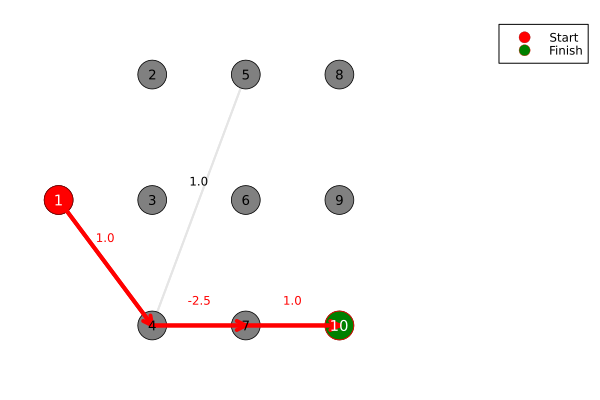

In [37]:
let
    # initialize -
    base_graphmodel = directedgraphmodel;
    source_node = 1; # this is the source node (you)
    target_node = 10; # TODO: this is the project completion node, update as needed
    shortest_path_nodes = reconstruct_path(p,  target_node); # reconstruct the path to the project completion node (9)

    # build set of edges on the shortest path for quick lookup
    path_edges = length(shortest_path_nodes) > 1 ? Set((shortest_path_nodes[i], shortest_path_nodes[i+1]) for i in 1:length(shortest_path_nodes)-1) : Set{Tuple{Int,Int}}()

    q = Plots.plot!();
    for (k,v) ∈ base_graphmodel.edgesinverse
       
        # now, get the source,target node index for this edge
        s = v[1];
        t = v[2];
        # draw baseline edge
        plot([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:gray90, lw=2, label="")
        # annotate the edge weight slightly above the midpoint unless this edge is on the shortest path
        if !((s,t) in path_edges)
            mx = (node_coordinates[s,1] + node_coordinates[t,1]) / 2
            my = (node_coordinates[s,2] + node_coordinates[t,2]) / 2
            w = round(base_graphmodel.edges[(s,t)], digits=2)
            Plots.annotate!(mx, my + 0.15, text(string(w), 8, :black))
        end
    end
    
    Plots.scatter!(node_coordinates[:,1], node_coordinates[:,2], axis=nothing, border=:none, label="", c=:gray, ms=16)
    Plots.scatter!([node_coordinates[source_node,1]], [node_coordinates[source_node,2]], 
             c=:red, ms=16, markerstroke=2, markerstrokecolor=:darkred, 
             label="Start")

    Plots.scatter!([node_coordinates[target_node,1]], [node_coordinates[target_node,2]], 
             c=:green, ms=16, markerstroke=2, markerstrokecolor=:red, 
             label="Finish")

    # plot path -
    for i in 1:length(shortest_path_nodes)-1
        s = shortest_path_nodes[i]
        t = shortest_path_nodes[i+1]
        Plots.plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:red, lw=4, label="")
        # annotate the path-edge weight in red slightly above the red edge
        mwx = (node_coordinates[s,1] + node_coordinates[t,1]) / 2
        mwy = (node_coordinates[s,2] + node_coordinates[t,2]) / 2
        w = round(base_graphmodel.edges[(s,t)], digits=2)
        Plots.annotate!(mwx, mwy + 0.20, text(string(w), 8, :red))
    end

    n_nodes = size(node_coordinates, 1)
    for i in 1:n_nodes
        x = node_coordinates[i,1]
        y = node_coordinates[i,2]
        if i == source_node || i == target_node
            # white text for the red source node
            Plots.annotate!(x, y, text(string(i), 10, :white))
        else
            # black text for other nodes
            Plots.annotate!(x, y, text(string(i), 9, :black))
        end
    end

    Plots.plot!(axis=nothing, border=:none, legend=:outertopright, legendfontsize=8, 
          background_color=:white, xlim=(9.5, 14.5), ylim=(8.5, 11.5))

    current()
end

In [38]:
do_I_see_the_path_figure = true; # {true,false} - set to true if you see the path figure, otherwise set to false

### Hmm. But wait, there's a problem!
Our current strategy assigns each task to the single worker who likes it most. But this has some limitations.
For example, in the (default) edge file, worker 3 is never assigned to any task, and worker 4 is assigned to multiple tasks, which may not be feasible in practice.

Thus, a shorter path from source `1` to a sink {8, 9, 10} doesn't guarantee a valid assignment of workers to tasks. We are not respecting the idea of __capacity constraints__ for each worker, e.g., maybe some workers can do multiple tasks, while others can only do one (or none).

For this we need to expand our shortest-path formulation to a full __minimum-cost flow__ problem, which we'll do in future lectures and problem sets.

___

## Summary
In this activity, we applied the Bellman-Ford algorithm to solve a task allocation problem with worker preferences. The problem demonstrated why __negative edge weights__ matter in real-world optimization: workers' preferences (negative weights) and dislikes (positive weights) created a graph that Dijkstra's algorithm couldn't handle.

> __Key insights:__ Our bipartite graph structure simplified the optimization because paths from source to completion must go through exactly one worker and one task. This meant the total path cost was determined solely by worker preferences, making our intuitive argmin approach match Bellman-Ford's globally optimal solution perfectly.

> __Algorithm verification:__ The verification table confirmed that our intuition was correct—the workers assigned by Bellman-Ford matched our predictions based on strongest preferences (most negative weights). This demonstrates how well-structured problems can make complex algorithms more interpretable.

> __Real-world formulation:__ In practice, workforce allocation problems are typically solved as __minimum cost maximum flow__ problems rather than shortest path problems. This allows for capacity constraints (e.g., worker availability, task requirements) and multiple assignments. Our shortest path approach works sometimes, but the min-cost max-flow formulation is more appropriate for real-world scenarios.

___

## Tests
The code blocks below contain tests to verify the correctness of the implementation. Run these tests to ensure everything is functioning as expected.

In [43]:
@testset verbose = true "Tests for Bellman-Ford Shortest Path Implementation" begin

    @testset "Graph struct tests" begin
        @test isnothing(myedgemodels) == false # we should have edge models
        @test isnothing(directedgraphmodel) == false # we should have a graph model
        @test length(directedgraphmodel.nodes) == 10 # we should have 10 nodes
        @test length(directedgraphmodel.edges) == 15 # we should have 15 edges
        @test isempty(W) == false # we should have a weight matrix
    end

    @testset "Plots and tables tests" begin
        @test do_I_see_my_graph_figure == true # did we see the graph figure?
        @test do_I_see_the_task_table == true # did we see the task table?
        @test do_I_see_the_path_figure == true # did we see the path figure?
    end
end;

Test Summary:                                       | Pass  Total  Time
Tests for Bellman-Ford Shortest Path Implementation |    8      8  0.3s
  Graph struct tests                                |    5      5  0.2s
  Plots and tables tests                            |    3      3  0.0s
